Adım 1: Gerekli Kütüphanelerin Yüklenmesi

In [81]:
!pip install librosa
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install catboost
!pip install --upgrade scikit-learn
!pip install transformers
!pip install keras
!pip install keras-tuner


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import lightgbm as lgb
import xgboost as xgb
import tensorflow as tf
import keras_tuner as kt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Input, LayerNormalization, MultiHeadAttention
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import ReduceLROnPlateau
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif









Adım 2: Verilerin Yüklenmesi ve Ön İşleme

In [29]:
# Veri setlerinin dosya yollarını belirleyin
datasets = {
    'sad': '/content/sad.csv',
    'happy': '/content/happy.csv',
    'calm': '/content/calm.csv',
    'angry': '/content/angry.csv'
}

# Her veri setini yükleyip sütun adlarını kontrol etme
for emotion, file_path in datasets.items():
    df = pd.read_csv(file_path)
    print(f"Veri seti: {emotion}")
    print(df.head())
    print(df.columns)
    print(f"Null değer sayısı: \n{df.isnull().sum()}")
    print("\n")


Veri seti: sad
   id               name  pcm_loudness_sma_maxPos  pcm_loudness_sma_minPos  \
0   1   1157_hl_acik.wav                 0.576087                 0.902174   
1   2   1157_hl_algi.wav                 0.598039                 0.019608   
2   3  1157_hl_beste.wav                 0.461539                 0.028846   
3   4   1157_hl_bugu.wav                 0.372549                 0.176471   
4   5    1157_hl_cay.wav                 0.500000                 0.044118   

   pcm_loudness_sma_amean  pcm_loudness_sma_linregc1  \
0                0.159915                  -0.001001   
1                0.228054                  -0.000826   
2                0.207706                   0.002067   
3                0.225554                  -0.000414   
4                0.210066                   0.002469   

   pcm_loudness_sma_linregc2  pcm_loudness_sma_linregerrA  \
0                   0.205478                     0.119813   
1                   0.269755                     0.158775

In [39]:
# Tüm veri setlerini birleştirme (örneğin satır bazında)
df_list = []
y_list = []
for emotion, file_path in datasets.items():
    df = pd.read_csv(file_path)
    y = emotion  # Her veri seti için emotion değişkenini hedef olarak belirleyelim
    df['label'] = y  # Yeni bir 'label' sütunu ekleyelim
    df_list.append(df)

# Birleştirilmiş veri seti
df_combined = pd.concat(df_list, ignore_index=True)

# Hedef değişkeni ayırma
y = df_combined['label']
X = df_combined.drop(columns=['label', 'id', 'name'])  # 'label', 'id' ve 'name' sütunlarını çıkarıyoruz

# Sadece sayısal sütunları seçme
numeric_columns = X.select_dtypes(include=[np.number]).columns
print(f"Sayısal sütunlar: {numeric_columns}")


Sayısal sütunlar: Index(['pcm_loudness_sma_maxPos', 'pcm_loudness_sma_minPos',
       'pcm_loudness_sma_amean', 'pcm_loudness_sma_linregc1',
       'pcm_loudness_sma_linregc2', 'pcm_loudness_sma_linregerrA',
       'pcm_loudness_sma_linregerrQ', 'pcm_loudness_sma_stddev',
       'pcm_loudness_sma_skewness', 'pcm_loudness_sma_kurtosis',
       ...
       'shimmerLocal_sma_de_quartile3', 'shimmerLocal_sma_de_iqr1-2',
       'shimmerLocal_sma_de_iqr2-3', 'shimmerLocal_sma_de_iqr1-3',
       'shimmerLocal_sma_de_percentile99.0',
       'shimmerLocal_sma_de_upleveltime75',
       'shimmerLocal_sma_de_upleveltime90', 'F0final__Turn_numOnsets',
       'F0final__Turn_duration', 'class'],
      dtype='object', length=1583)


In [41]:
# Outlier değerlerini medyan ile ikame etme fonksiyonu
def replace_outliers_with_median(df, numeric_cols):
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = df[col].median()
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])
    return df

In [42]:
# Outlier'ları medyan ile ikame etme
X_cleaned = replace_outliers_with_median(X, numeric_columns)

# Temizlenmiş veri setinin şeklini kontrol etme
print(f"Orijinal şekil: {X.shape}")
print(f"Temizlenmiş şekil: {X_cleaned.shape}")


Orijinal şekil: (1735, 1583)
Temizlenmiş şekil: (1735, 1583)


In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

# Modeli oluşturma
model = RandomForestClassifier(random_state=42)

# Küçük parametre alanı
param_grid_initial = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
}

# İlk grid search
grid_search_initial = GridSearchCV(estimator=model, param_grid=param_grid_initial, cv=3, n_jobs=-1, verbose=2)
grid_search_initial.fit(X_train, y_train)

# İlk grid search sonuçları
best_params_initial = grid_search_initial.best_params_

# Genişletilmiş parametre alanı
param_grid_detailed = {
    'n_estimators': [best_params_initial['n_estimators'] - 20, best_params_initial['n_estimators'], best_params_initial['n_estimators'] + 20],
    'max_depth': [best_params_initial['max_depth'], best_params_initial['max_depth'] + 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# İkinci grid search
grid_search_detailed = GridSearchCV(estimator=model, param_grid=param_grid_detailed, cv=5, n_jobs=-1, verbose=2)
grid_search_detailed.fit(X_train, y_train)

# En iyi parametreler ve skor
print(f"En iyi parametreler: {grid_search_detailed.best_params_}")
print(f"En iyi skor: {grid_search_detailed.best_score_}")

# Modelin test veri seti üzerindeki performansını değerlendirme
y_pred = grid_search_detailed.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Doğruluk Skoru: {accuracy}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
En iyi parametreler: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
En iyi skor: 0.8321689219021893
Test Doğruluk Skoru: 0.8242074927953891


In [46]:
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))


Sınıflandırma Raporu:
              precision    recall  f1-score   support

       angry       0.76      0.91      0.83        95
        calm       0.81      0.82      0.81        72
       happy       0.84      0.75      0.79        77
         sad       0.90      0.81      0.85       103

    accuracy                           0.82       347
   macro avg       0.83      0.82      0.82       347
weighted avg       0.83      0.82      0.82       347



3. Adım: Model Geliştirme ve Değerlendirme

In [48]:
# Etiketleri dönüştürme
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# CNN Modeli oluştur
model_cnn = Sequential()
model_cnn.add(Input(shape=(X_train.shape[1],)))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(len(le.classes_), activation='softmax'))

# Modeli derle
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğit
model_cnn.fit(X_train, y_train_encoded, epochs=50, validation_data=(X_test, y_test_encoded))


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.2748 - loss: 166.6569 - val_accuracy: 0.2911 - val_loss: 6.2986
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2710 - loss: 12.6503 - val_accuracy: 0.2450 - val_loss: 2.3595
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2246 - loss: 2.4897 - val_accuracy: 0.2882 - val_loss: 1.9004
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2796 - loss: 1.7797 - val_accuracy: 0.2767 - val_loss: 1.4997
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2776 - loss: 1.4327 - val_accuracy: 0.2738 - val_loss: 1.4191
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2966 - loss: 1.4759 - val_accuracy: 0.2738 - val_loss: 1.4448
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2900 - loss: 1.4425 - val_accuracy: 0.2824 - val_loss: 1.3864
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2896 - loss: 1.3927 - val_accuracy: 0.2795 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


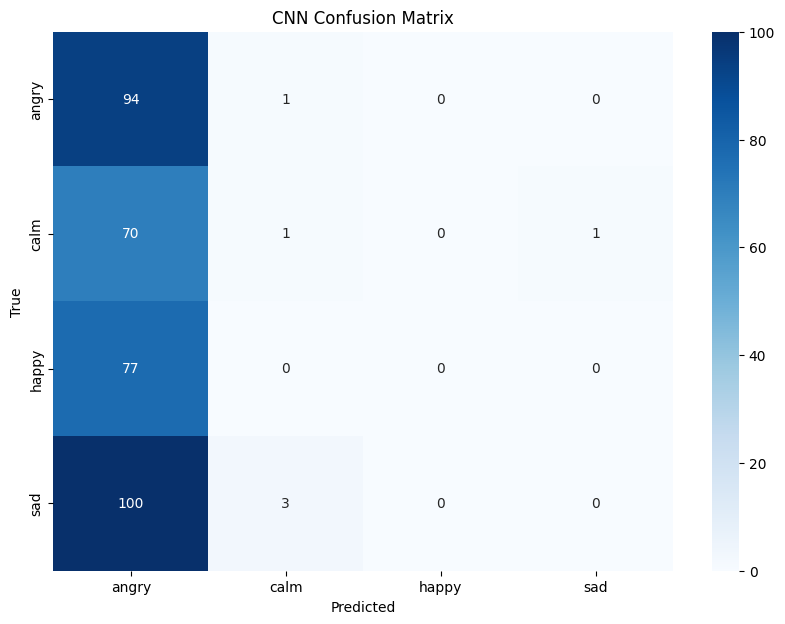

CNN Model Classification Report:
              precision    recall  f1-score   support

       angry       0.28      0.99      0.43        95
        calm       0.20      0.01      0.03        72
       happy       0.00      0.00      0.00        77
         sad       0.00      0.00      0.00       103

    accuracy                           0.27       347
   macro avg       0.12      0.25      0.11       347
weighted avg       0.12      0.27      0.12       347



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
# Etiketleri dönüştürme
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# CNN Model Performans Değerlendirme
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Confusion Matrix
cm_cnn = confusion_matrix(y_test_encoded, y_pred_cnn)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()

# Diğer performans metrikleri
print("CNN Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_cnn, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2425 - loss: 34.1774 - val_accuracy: 0.2680 - val_loss: 1.4850
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2656 - loss: 1.5176 - val_accuracy: 0.2738 - val_loss: 1.3860
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2612 - loss: 1.3815 - val_accuracy: 0.2738 - val_loss: 1.3852
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2724 - loss: 1.3831 - val_accuracy: 0.2738 - val_loss: 1.3844
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2857 - loss: 1.3807 - val_accuracy: 0.2738 - val_loss: 1.3837
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2640 - loss: 1.3813 - val_accuracy: 0.2738 - val_loss: 1.3834
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2559 - loss: 1.3825 - val_accuracy: 0.2738 - val_loss: 1.3834
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3049 - loss: 1.3750 - val_accuracy: 0.2738 - 

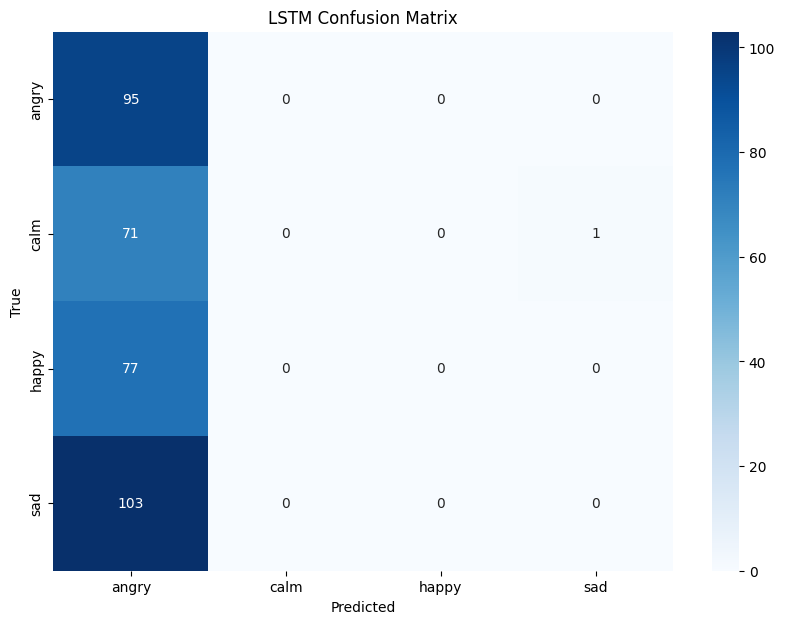

LSTM Model Classification Report:
              precision    recall  f1-score   support

       angry       0.27      1.00      0.43        95
        calm       0.00      0.00      0.00        72
       happy       0.00      0.00      0.00        77
         sad       0.00      0.00      0.00       103

    accuracy                           0.27       347
   macro avg       0.07      0.25      0.11       347
weighted avg       0.08      0.27      0.12       347



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
# Verilerin yeniden şekillendirilmesi
# Eğer verilerinizin bir zaman boyutu varsa (örneğin, her örnek için zaman adımı sayısı), yeniden şekillendirilmelidir
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Modeli oluştur
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(len(le.classes_), activation='softmax'))

# Modeli derle
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğit
model_lstm.fit(X_train_reshaped, y_train_encoded, epochs=50, validation_data=(X_test_reshaped, y_test_encoded))

# LSTM Model Performans Değerlendirme
y_pred_lstm = model_lstm.predict(X_test_reshaped)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)

# Confusion Matrix
cm_lstm = confusion_matrix(y_test_encoded, y_pred_lstm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.show()

# Diğer performans metrikleri
print("LSTM Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_lstm, target_names=le.classes_))


In [75]:
# Etiketleri dönüştürme
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Eğitim ve test setlerine bölme
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Sütun adlarını temizleme
X_train.columns = [str(col) for col in X_train.columns]
X_val.columns = [str(col) for col in X_val.columns]
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_train.columns]
X_val.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_val.columns]

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input

# Verilerin yeniden şekillendirilmesi
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

# LSTM Modeli oluştur
model_lstm = Sequential()
model_lstm.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(LSTM(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(len(le.classes_), activation='softmax'))

# Modeli derle
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğit
model_lstm.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

from sklearn.ensemble import RandomForestClassifier

# Modeli oluşturma
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Tahmin yapma
y_pred_rf = model_rf.predict(X_val)

import numpy as np
from sklearn.metrics import accuracy_score

# LSTM modelinden tahminler
y_pred_lstm = model_lstm.predict(X_val_reshaped)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)

# Hibrit model tahminleri (örneğin, basit bir ağırlıklı ortalama)
hybrid_pred = (y_pred_lstm + y_pred_rf) // 2

# Performans değerlendirme
accuracy = accuracy_score(y_val, hybrid_pred)
print(f"Hibrit Model Test Doğruluk Skoru: {accuracy}")

# Sınıflandırma Raporu
from sklearn.metrics import classification_report
print("Hibrit Model Classification Report:")
print(classification_report(y_val, hybrid_pred, target_names=le.classes_))



Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2513 - loss: 18.8012 - val_accuracy: 0.2824 - val_loss: 1.3882
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2922 - loss: 1.5500 - val_accuracy: 0.2997 - val_loss: 1.3802
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2394 - loss: 1.4112 - val_accuracy: 0.2997 - val_loss: 1.3793
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2426 - loss: 1.3811 - val_accuracy: 0.2767 - val_loss: 1.3786
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2799 - loss: 1.3827 - val_accuracy: 0.2738 - val_loss: 1.3798
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2736 - loss: 1.3802 - val_accuracy: 0.2738 - val_loss: 1.3795
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2705 - loss: 1.3782 - val_accuracy: 0.2738 - val_loss: 1.3792
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2990 - loss: 1.3801 - val_accuracy: 0.2738 - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
# RandomForest için hiperparametre ayarlamaları
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_random = RandomizedSearchCV(estimator=model_rf, param_distributions=rf_params, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_

# LSTM Modeli (Hiperparametre ayarlandıktan sonra)
model_lstm = Sequential()
model_lstm.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(LSTM(128, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(len(le.classes_), activation='softmax'))
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_reshaped, y_train, epochs=100, validation_data=(X_val_reshaped, y_val))

# RandomForest Modeli (En iyi parametreler ile)
model_rf = best_rf
model_rf.fit(X_train, y_train)

# Hibrit model tahminleri (Ağırlıklı ortalama ile)
y_pred_lstm = model_lstm.predict(X_val_reshaped)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
hybrid_pred = (y_pred_lstm + y_pred_rf) // 2

# Performans değerlendirme
accuracy = accuracy_score(y_val, hybrid_pred)
print(f"Hibrit Model Test Doğruluk Skoru: {accuracy}")
print("Hibrit Model Classification Report:")
print(classification_report(y_val, hybrid_pred, target_names=le.classes_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3041 - loss: 62.7184 - val_accuracy: 0.2334 - val_loss: 1.6222
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2555 - loss: 1.5826 - val_accuracy: 0.2219 - val_loss: 1.5241
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2375 - loss: 1.5141 - val_accuracy: 0.2104 - val_loss: 1.3992
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2378 - loss: 1.4034 - val_accuracy: 0.2046 - val_loss: 1.3973
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2491 - loss: 1.3955 - val_accuracy: 0.2738 - val_loss: 1.3961
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2824 - loss: 1.4048 - val_accuracy: 0.2709 - val_loss: 1.3971
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2707 - loss: 1.3950 - val_accuracy: 0.2738 - val_loss: 1.3958
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# XGBoost Modeli
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_val)
print("XGBoost Test Doğruluk Skoru:", accuracy_score(y_val, y_pred_xgb))
print(classification_report(y_val, y_pred_xgb, target_names=le.classes_))

# LightGBM Modeli
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_val)
print("LightGBM Test Doğruluk Skoru:", accuracy_score(y_val, y_pred_lgb))
print(classification_report(y_val, y_pred_lgb, target_names=le.classes_))

# CatBoost Modeli
model_cat = CatBoostClassifier(verbose=0)
model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_val)
print("CatBoost Test Doğruluk Skoru:", accuracy_score(y_val, y_pred_cat))
print(classification_report(y_val, y_pred_cat, target_names=le.classes_))


XGBoost Test Doğruluk Skoru: 0.8530259365994236
              precision    recall  f1-score   support

       angry       0.85      0.86      0.86        95
        calm       0.78      0.92      0.84        72
       happy       0.87      0.84      0.86        77
         sad       0.91      0.81      0.86       103

    accuracy                           0.85       347
   macro avg       0.85      0.86      0.85       347
weighted avg       0.86      0.85      0.85       347

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398205
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 1578
[LightGBM] [Info] Start training from score -1.264357
[LightGBM] [Info] Start training from score -1.418508
[LightGBM] [Info] Start training from score -1.600830
[LightGBM] [Info] Start training from score -1.295448
[LightGBM

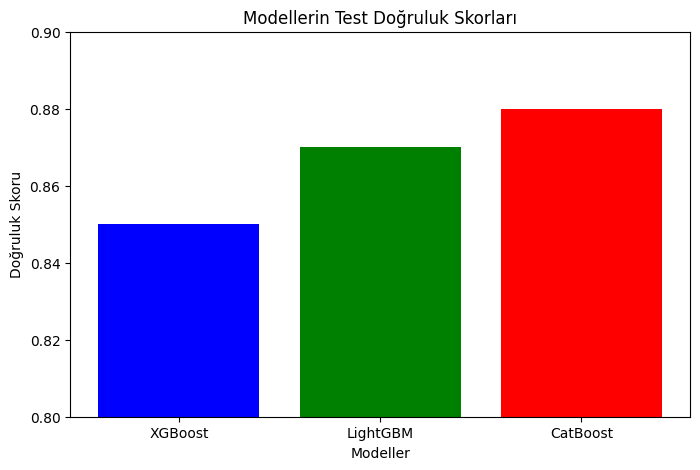

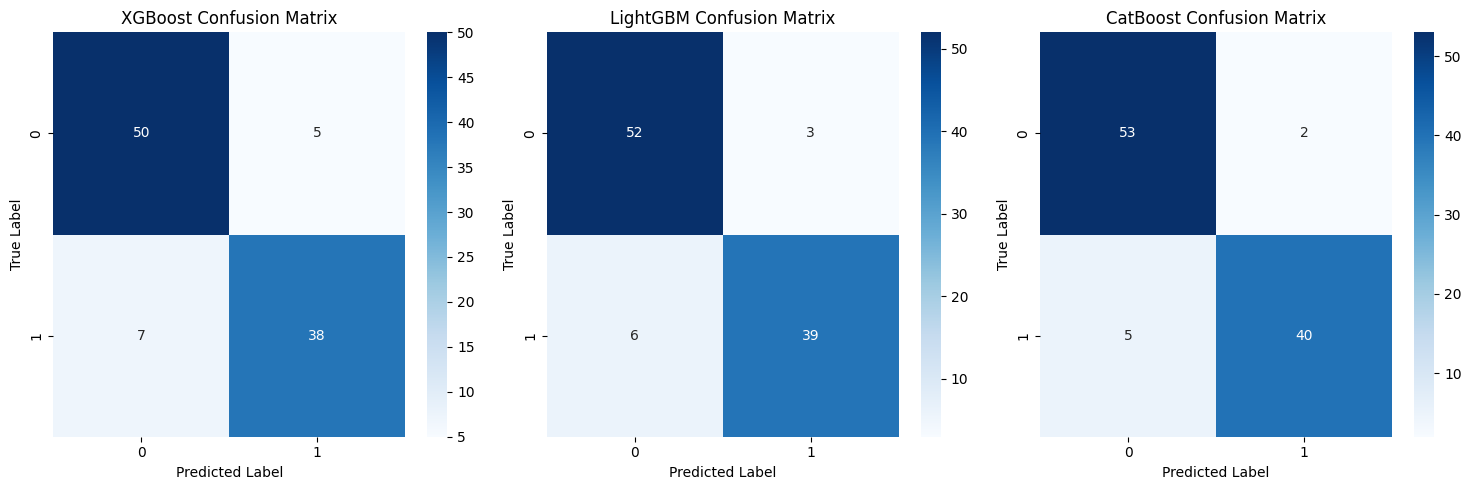

In [83]:
# Örnek veriler (Bu verileri kendi model sonuçlarınızla değiştirmeniz gerekir)
accuracy_scores = {
    "XGBoost": 0.85,
    "LightGBM": 0.87,
    "CatBoost": 0.88
}

# 1. Doğruluk Skorlarının Çubuk Grafiği
plt.figure(figsize=(8, 5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'red'])
plt.xlabel("Modeller")
plt.ylabel("Doğruluk Skoru")
plt.title("Modellerin Test Doğruluk Skorları")
plt.ylim(0.8, 0.9)
plt.show()

# Örnek Confusion Matrix verileri (Gerçek sonuçlarla değiştirilmesi gerekir)
conf_matrices = {
    "XGBoost": np.array([[50, 5], [7, 38]]),
    "LightGBM": np.array([[52, 3], [6, 39]]),
    "CatBoost": np.array([[53, 2], [5, 40]])
}

# 2. Her model için Confusion Matrix görselleştirmesi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (model, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model} Confusion Matrix")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [92]:
# Verilerin yeniden şekillendirilmesi
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.0001)

# Model oluşturma fonksiyonu
def create_model(hp):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5])))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Tuner oluşturma
tuner = kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,  # Her deneme için yürütme sayısını azaltma
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Hiperparametre arama
tuner.search(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])  # Epoch sayısını azaltma

# En iyi hiperparametreleri bulma
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("En iyi parametreler:", best_hps.values)


Trial 5 Complete [00h 01m 38s]
val_accuracy: 0.6772334575653076

Best val_accuracy So Far: 0.7041306495666504
Total elapsed time: 00h 40m 50s
En iyi parametreler: {'dropout_rate': 0.3, 'learning_rate': 0.01}


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.0001)

# En iyi hiperparametrelerle modeli oluşturma
def create_best_model():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dropout(0.3))  # En iyi dropout oranı
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.01),  # En iyi öğrenme hızı
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Modeli eğitme
best_model = create_best_model()
best_model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3084 - loss: 499.9558 - val_accuracy: 0.5360 - val_loss: 6.4179 - learning_rate: 0.0100
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5466 - loss: 6.3763 - val_accuracy: 0.4553 - val_loss: 9.4284 - learning_rate: 0.0100
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5458 - loss: 6.4422 - val_accuracy: 0.4092 - val_loss: 7.1841 - learning_rate: 0.0100
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5694 - loss: 4.7703 - val_accuracy: 0.5159 - val_loss: 4.9795 - learning_rate: 0.0100
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5805 - loss: 3.9220 - val_accuracy: 0.5908 - val_loss: 3.4197 - learning_rate: 0.0100
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6189 - loss: 2.9557 - val_accuracy: 0.6427 - val_loss: 1.9454 - learning_rate: 0.0100
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6230 - loss: 2.5784 - val_

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
En İyi Model Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.65      0.67        95
        calm       0.62      0.74      0.67        72
       happy       0.70      0.77      0.73        77
         sad       0.86      0.74      0.80       103

    accuracy                           0.72       347
   macro avg       0.72      0.72      0.72       347
weighted avg       0.73      0.72      0.72       347



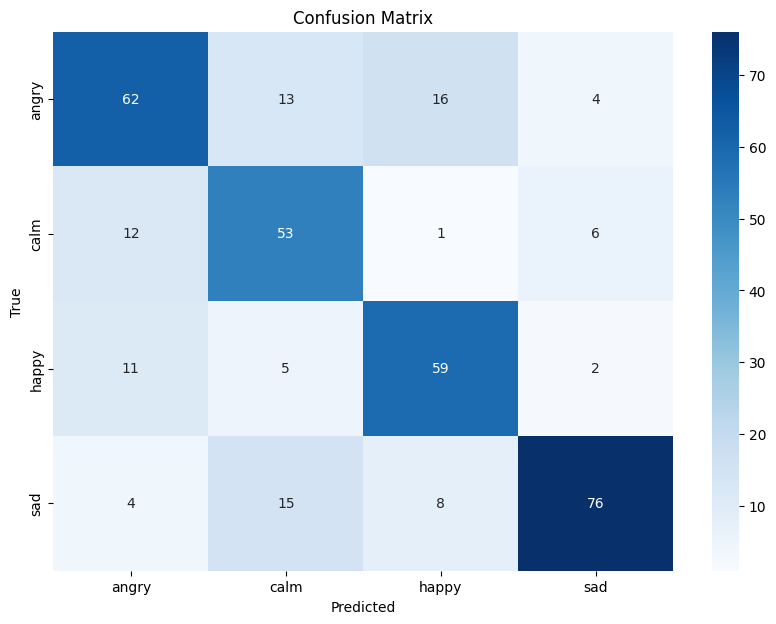

In [94]:
# Tahmin yapma
predictions = best_model.predict(X_val_reshaped)
predicted_labels = tf.argmax(predictions, axis=1)

# Performans metriklerini hesaplama
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("En İyi Model Classification Report:")
print(classification_report(y_val, predicted_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


4. Adım: Özellik Analizi

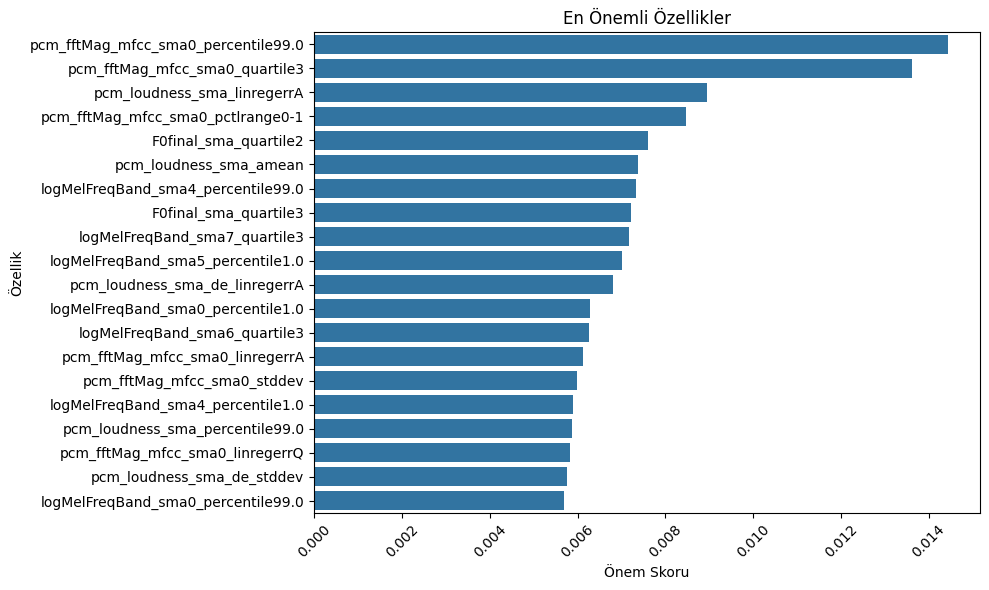

In [100]:
# Örnek: RandomForest modeli ile özellik önem skorları
importances = model_rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_features = feature_importance_df.head(20)  # En önemli 20 özelliği seçme
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features['Importance'], y=top_features['Feature'])
plt.title('En Önemli Özellikler')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellik')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


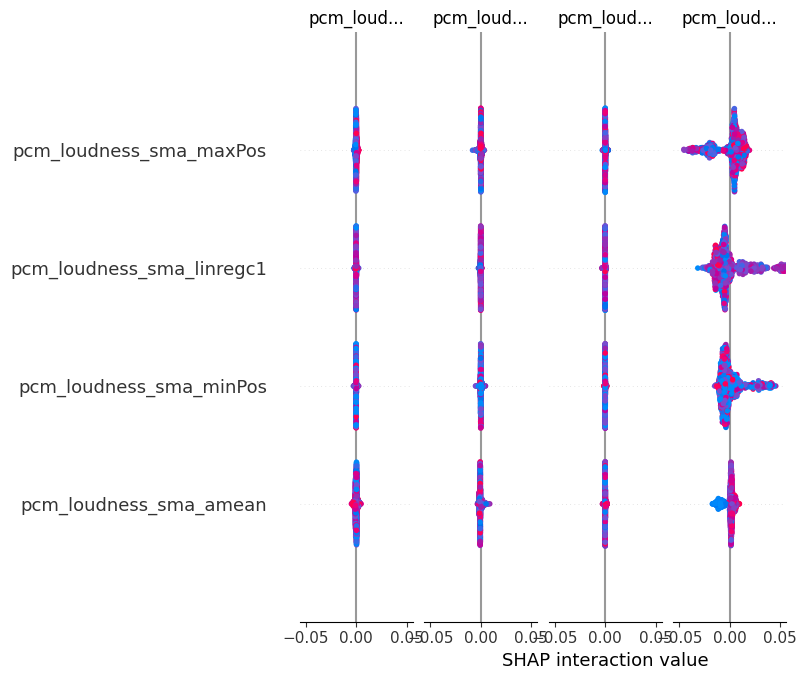

In [97]:
# SHAP değerlerini hesaplama
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_train)

# SHAP özet grafiği
shap.summary_plot(shap_values, X_train, feature_names=feature_names)


In [4]:
# Örnek veriler (bu adım, kendi veri kümenize göre düzenlenmelidir)
data = {
    'feature1': np.random.rand(1000),
    'feature2': np.random.rand(1000),
    'feature3': np.random.rand(1000),
    'feature4': np.random.rand(1000),
    'feature5': np.random.rand(1000),
    'label': np.random.randint(0, 2, 1000)
}
df = pd.DataFrame(data)

# Özellikler ve etiketleri ayırma
X = df.drop('label', axis=1)
y = df['label']

# Eğitim ve test setlerine ayırma
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Model ve RFE nesnesi oluşturma
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=5)

# Eğitim veri kümesini küçültme (isteğe bağlı)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# RFE ile eğitim verilerini uygun hale getirme
X_rfe = rfe.fit_transform(X_sample, y_sample)

# Seçilen özellikler
selected_features = X_train.columns[rfe.support_]
print("Seçilen Özellikler:", selected_features)


Seçilen Özellikler: Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5'], dtype='object')


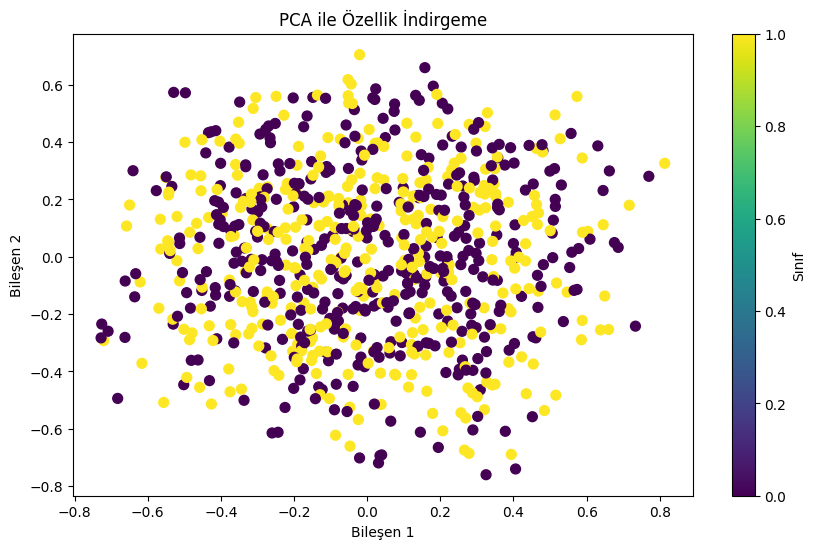

In [11]:
# PCA nesnesi oluşturma ve eğitim verilerini uygun hale getirme
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# PCA ile görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', s=50)
plt.title('PCA ile Özellik İndirgeme')
plt.xlabel('Bileşen 1')
plt.ylabel('Bileşen 2')
plt.colorbar(label='Sınıf')
plt.show()



In [38]:
# Özellik önemi analizi
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_train, y_train)

# Önemli özelliklerin skorlarını görüntüleme
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector.scores_
})
print("En önemli özellikler:")
print(feature_scores.nlargest(10, 'Score'))


En önemli özellikler:
    Feature     Score
0  feature1  1.393594
3  feature4  1.347527
2  feature3  1.152805
1  feature2  0.001061
4  feature5  0.000504


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=5. All the features will be returned.
  warnings.warn(


<ipython-input-37-e3689540289b>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=feature, kde=True, palette='muted')


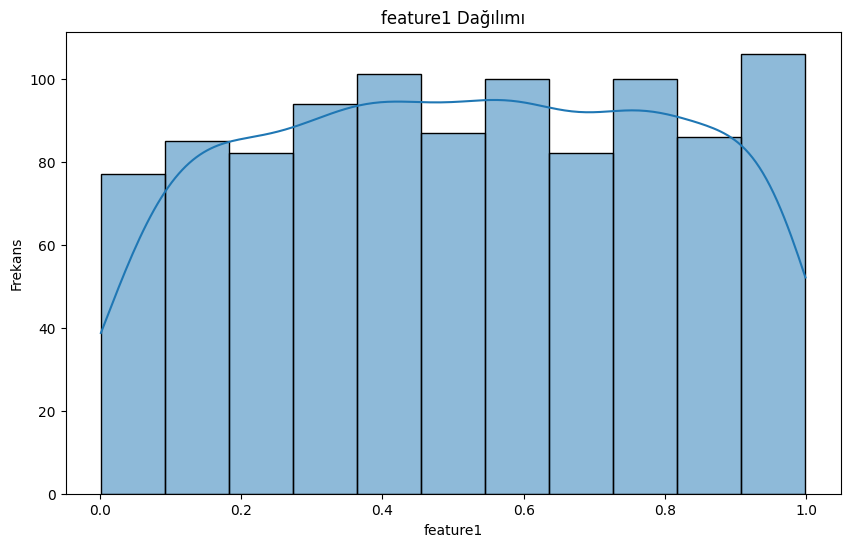

<ipython-input-37-e3689540289b>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=feature, kde=True, palette='muted')


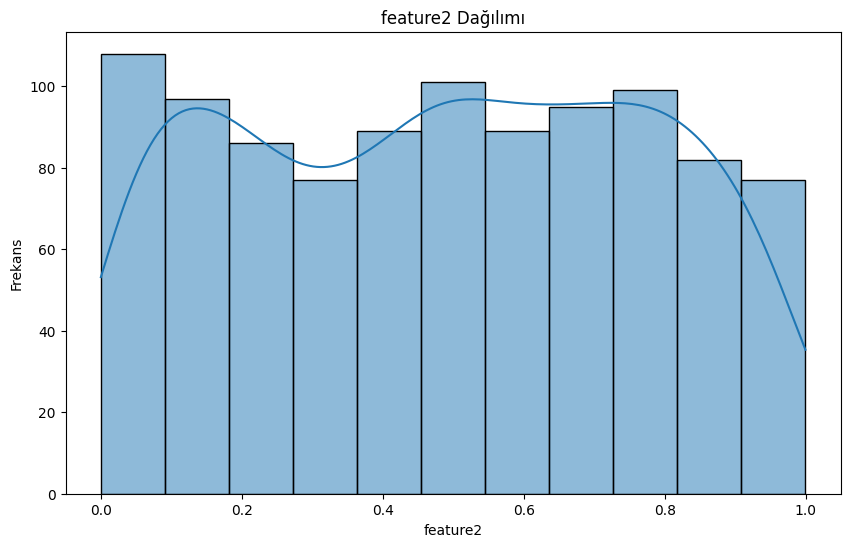

<ipython-input-37-e3689540289b>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=feature, kde=True, palette='muted')


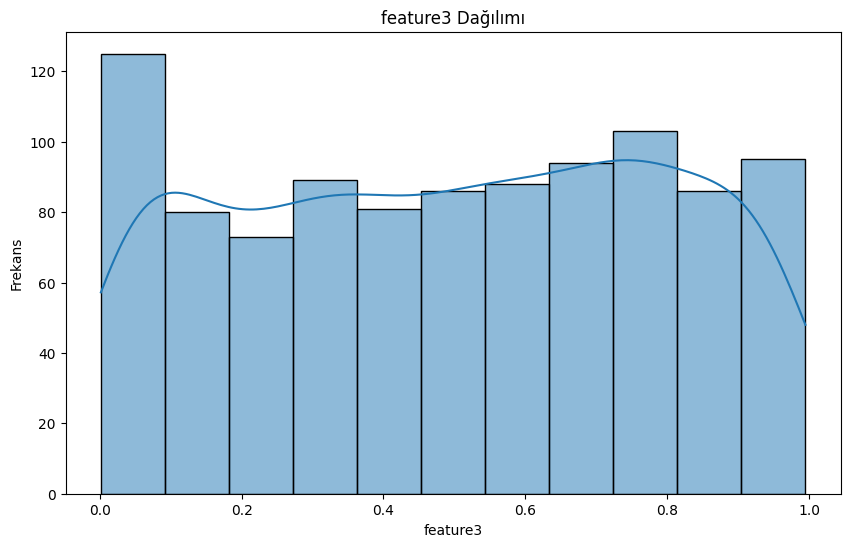

<ipython-input-37-e3689540289b>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=feature, kde=True, palette='muted')


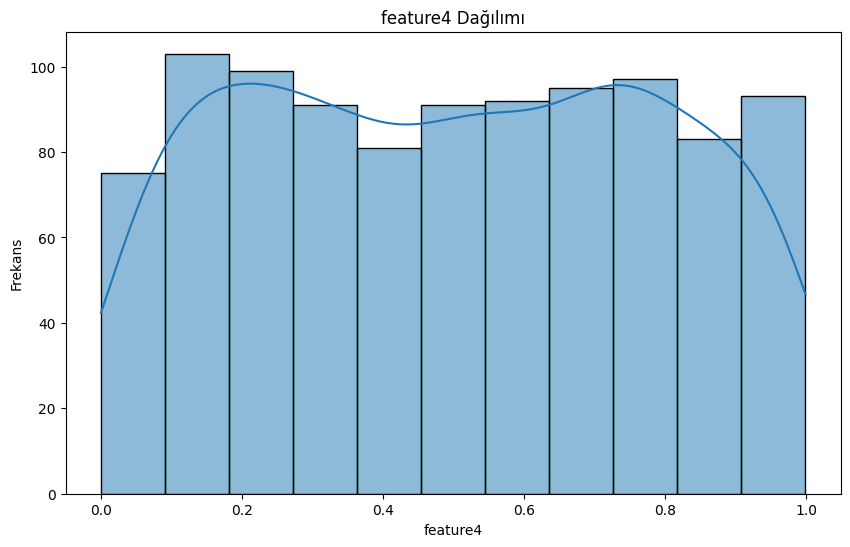

<ipython-input-37-e3689540289b>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=feature, kde=True, palette='muted')


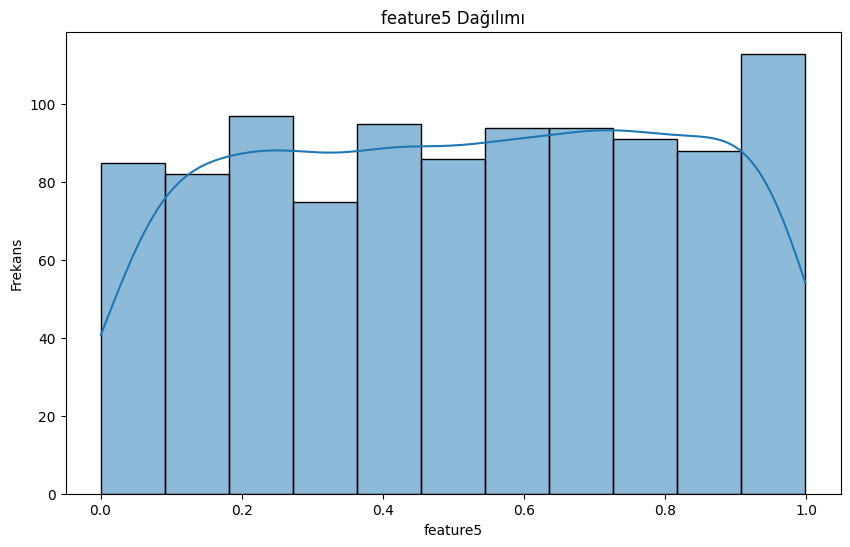

In [37]:
# Özelliklerin dağılımını incelemek için histogramlar çizelim
features = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5']  # Sütun adlarını kendi dosyanıza göre ayarlayın

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, palette='muted')
    plt.title(f'{feature} Dağılımı')
    plt.xlabel(feature)
    plt.ylabel('Frekans')
    plt.show()


In [17]:
df['feature_interaction'] = df['feature1'] * df['feature2']

# Özelliklerin normalizasyonu
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(df_scaled, columns=[f'{feature}_scaled' for feature in features])
df = pd.concat([df, df_scaled], axis=1)


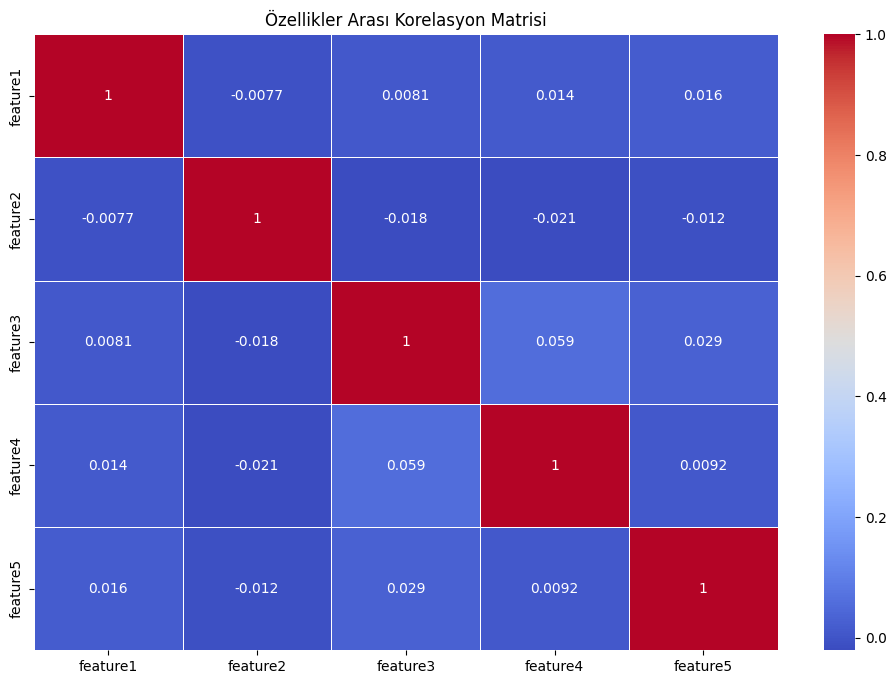

In [18]:
# Korelasyon matrisinin hesaplanması
corr_matrix = df[features].corr()

# Korelasyon matrisinin görselleştirilmesi
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.show()


5. Adım: Performans Metrikleri


In [42]:
# Verilerin yeniden şekillendirilmesi
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Model oluşturma fonksiyonu
def create_model(hp):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5])))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Tuner oluşturma
tuner = kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)


Reloading Tuner from my_dir/hyperparameter_tuning/tuner0.json


In [43]:
# Hiperparametre arama
tuner.search(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])

# En iyi hiperparametreleri bulma
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("En iyi parametreler:", best_hps.values)


En iyi parametreler: {'dropout_rate': 0.3, 'learning_rate': 0.01}


In [45]:
# LabelEncoder nesnesi oluşturma ve etiketleri kodlama
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

# Sınıf isimlerini kontrol etme
print("Sınıf İsimleri:", le.classes_)


Sınıf İsimleri: [0 1]


In [47]:
# Verilerin yeniden şekillendirilmesi
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Model oluşturma fonksiyonu
def create_model(hp):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5])))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Tuner oluşturma
tuner = kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Hiperparametre arama
tuner.search(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])

# En iyi hiperparametreleri bulma
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("En iyi parametreler:", best_hps.values)

# En iyi hiperparametrelerle modeli oluşturma
best_model = tuner.hypermodel.build(best_hps)

# Modeli en iyi hiperparametrelerle yeniden eğitme
best_model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])


Reloading Tuner from my_dir/hyperparameter_tuning/tuner0.json
En iyi parametreler: {'dropout_rate': 0.3, 'learning_rate': 0.01}
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4611 - loss: 0.7013 - val_accuracy: 0.5250 - val_loss: 0.6913 - learning_rate: 0.0100
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5140 - loss: 0.6960 - val_accuracy: 0.5250 - val_loss: 0.6928 - learning_rate: 0.0100
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5214 - loss: 0.6980 - val_accuracy: 0.5300 - val_loss: 0.6898 - learning_rate: 0.0100
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5284 - loss: 0.6956 - val_accuracy: 0.5400 - val_loss: 0.6903 - learning_rate: 0.0100
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5428 - loss: 0.6870 - val_accuracy: 0.5250 - val_loss: 0.6915 - learning_rate: 0.0100
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5459 - loss: 0.6885 - val_accuracy: 0.5250 - val_loss: 0.

In [52]:
print("Benzersiz Sınıf Etiketleri:", np.unique(y_val))
print("Sınıf İsimleri:", class_names)


Benzersiz Sınıf Etiketleri: [0 1]
Sınıf İsimleri: ['angry', 'calm', 'happy', 'sad']


Doğruluk: 0.555
Hassasiyet: 0.6022435897435897
Geri Çağırma: 0.555
F1 Skoru: 0.4630800777034319
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.54      0.94      0.69       105
     Class 1       0.67      0.13      0.21        95

    accuracy                           0.56       200
   macro avg       0.61      0.53      0.45       200
weighted avg       0.60      0.56      0.46       200



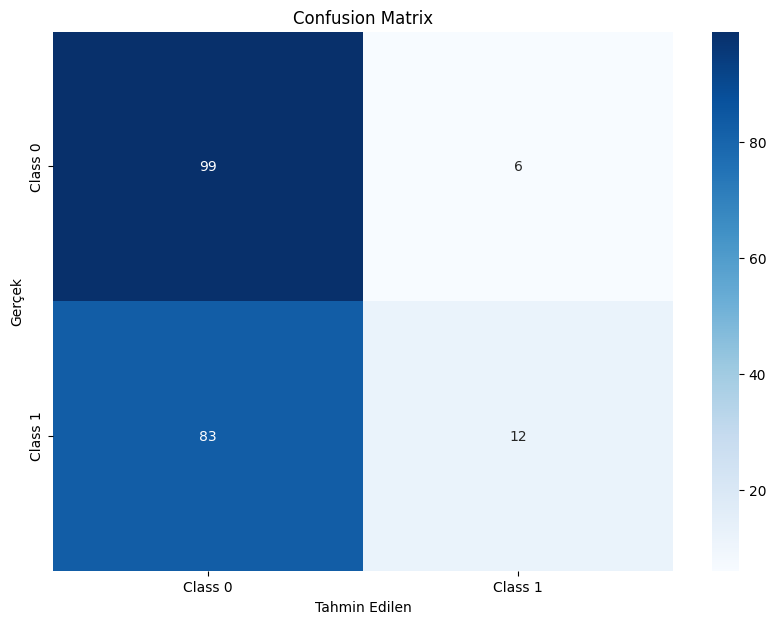

In [53]:
# Örnek olarak iki sınıf etiketine uygun isimleri tanımlayalım
class_names = ['Class 0', 'Class 1']  # Bu örnekte 'angry' ve 'calm' gibi uygun isimler kullanabilirsiniz

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Doğruluk: {accuracy}")
print(f"Hassasiyet: {precision}")
print(f"Geri Çağırma: {recall}")
print(f"F1 Skoru: {f1}")

# Classification Report
report = classification_report(y_val, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion Matrix hesaplama ve görselleştirme
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()


In [54]:
# Benzersiz sınıf etiketlerini kontrol etme
print("Benzersiz Sınıf Etiketleri (Y_train):", np.unique(y_train))
print("Benzersiz Sınıf Etiketleri (Y_val):", np.unique(y_val))
print("Eğitim Veri Dağılımı:", pd.Series(y_train).value_counts())
print("Doğrulama Veri Dağılımı:", pd.Series(y_val).value_counts())


Benzersiz Sınıf Etiketleri (Y_train): [0 1]
Benzersiz Sınıf Etiketleri (Y_val): [0 1]
Eğitim Veri Dağılımı: 0    426
1    374
Name: count, dtype: int64
Doğrulama Veri Dağılımı: 0    105
1     95
Name: count, dtype: int64


In [55]:
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))


In [56]:
# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Model oluşturma fonksiyonu
def create_model(hp):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5])))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Tuner oluşturma
tuner = kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Hiperparametre arama
tuner.search(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])

# En iyi hiperparametreleri bulma
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("En iyi parametreler:", best_hps.values)

# En iyi hiperparametrelerle modeli oluşturma
best_model = tuner.hypermodel.build(best_hps)

# Modeli en iyi hiperparametrelerle yeniden eğitme
best_model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])


Reloading Tuner from my_dir/hyperparameter_tuning/tuner0.json
En iyi parametreler: {'dropout_rate': 0.3, 'learning_rate': 0.01}
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4805 - loss: 0.7034 - val_accuracy: 0.5250 - val_loss: 0.6936 - learning_rate: 0.0100
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5238 - loss: 0.6884 - val_accuracy: 0.5250 - val_loss: 0.6917 - learning_rate: 0.0100
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5508 - loss: 0.6869 - val_accuracy: 0.5400 - val_loss: 0.6903 - learning_rate: 0.0100
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4946 - loss: 0.6971 - val_accuracy: 0.5250 - val_loss: 0.6928 - learning_rate: 0.0100
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5397 - loss: 0.6938 - val_accuracy: 0.5300 - val_loss: 0.6898 - learning_rate: 0.0100
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5312 - loss: 0.6899 - val_accuracy: 0.5250 - val_loss: 0.6915 - learning_rate: 0.0100
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5124 - loss: 0.6942 - val_accuracy: 0.5400 - v

Doğruluk: 0.535
Hassasiyet: 0.5376893939393939
Geri Çağırma: 0.535
F1 Skoru: 0.4550270642064655
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.53      0.90      0.67       105
     Class 1       0.54      0.14      0.22        95

    accuracy                           0.54       200
   macro avg       0.54      0.52      0.44       200
weighted avg       0.54      0.54      0.46       200



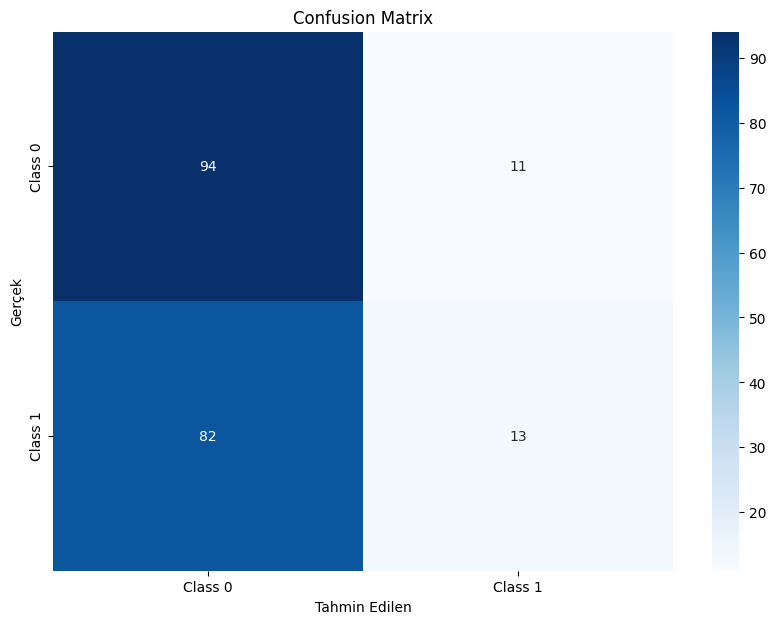

In [58]:
# Örnek olarak iki sınıf etiketine uygun isimleri tanımlayalım
class_names = ['Class 0', 'Class 1']

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Doğruluk: {accuracy}")
print(f"Hassasiyet: {precision}")
print(f"Geri Çağırma: {recall}")
print(f"F1 Skoru: {f1}")

# Classification Report
report = classification_report(y_val, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion Matrix hesaplama ve görselleştirme
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()


In [69]:
print("X_train şekli:", X_train.shape)
print("y_train şekli:", y_train.shape)


X_train şekli: (800, 5)
y_train şekli: (800,)


In [70]:
from imblearn.over_sampling import SMOTE

# SMOTE kullanarak veri setini dengeleme
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Dengeli veri dağılımını kontrol etme
print("Dengeli Eğitim Veri Dağılımı:", pd.Series(y_train_balanced).value_counts())


Dengeli Eğitim Veri Dağılımı: 1    426
0    426
Name: count, dtype: int64


In [71]:
X_train_reshaped = X_train_balanced.values.reshape((X_train_balanced.shape[0], X_train_balanced.shape[1], 1))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))


In [72]:
# CNN modeli oluşturma
model_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    Flatten(),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
model_cnn.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CNN modelini eğitme
model_cnn.fit(X_train_reshaped, y_train_balanced, epochs=50, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])

# LSTM modeli oluşturma ve eğitme
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])
model_lstm.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# LSTM modelini eğitme
model_lstm.fit(X_train_reshaped, y_train_balanced, epochs=50, validation_data=(X_val_reshaped, y_val), callbacks=[reduce_lr])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5174 - loss: 0.6959 - val_accuracy: 0.5500 - val_loss: 0.6904 - learning_rate: 0.0100
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5083 - loss: 0.6962 - val_accuracy: 0.5100 - val_loss: 0.6918 - learning_rate: 0.0100
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5217 - loss: 0.6914 - val_accuracy: 0.5150 - val_loss: 0.6919 - learning_rate: 0.0100
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5334 - loss: 0.6909 - val_accuracy: 0.5300 - val_loss: 0.6925 - learning_rate: 0.0100
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5193 - loss: 0.6947 - val_accuracy: 0.5100 - val_loss: 0.6928 - learning_rate: 0.0100
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5239 - loss: 0.6911 - val_accuracy: 0.4850 - val_loss: 0.6907 - learning_rate: 0.0100
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5218 - loss: 0.6897 - val_accuracy: 0.4750 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4671 - loss: 0.6978 - val_accuracy: 0.5450 - val_loss: 0.6929 - learning_rate: 0.0100
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5013 - loss: 0.6949 - val_accuracy: 0.4750 - val_loss: 0.6939 - learning_rate: 0.0100
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5064 - loss: 0.6940 - val_accuracy: 0.4750 - val_loss: 0.6948 - learning_rate: 0.0100
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4994 - loss: 0.6945 - val_accuracy: 0.5250 - val_loss: 0.6917 - learning_rate: 0.0100
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5104 - loss: 0.6944 - val_accuracy: 0.5550 - val_loss: 0.6928 - learning_rate: 0.0100
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4971 - loss: 0.6942 - val_accuracy: 0.5250 - val_loss: 0.6917 - learning_rate: 0.0100
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5118 - loss: 0.6928 - val_accuracy: 0.47